In [1]:
import collections.abc
import math
from dataclasses import dataclass
from typing import Callable, List, Optional, Set, Tuple, Union

import torch
import torch.utils.checkpoint
from torch import nn
from packaging import version

In [2]:
parsed_torch_version_base = version.parse(version.parse(torch.__version__).base_version)
is_torch_greater_or_equal_than_1_10 = parsed_torch_version_base >= version.parse("1.10")

def meshgrid(
    *tensors: Union[torch.Tensor, List[torch.Tensor]], indexing: Optional[str] = None
) -> Tuple[torch.Tensor, ...]:
    """
    Wrapper around torch.meshgrid to avoid warning messages about the introduced `indexing` argument.
    Reference: https://pytorch.org/docs/1.13/generated/torch.meshgrid.html
    """
    if is_torch_greater_or_equal_than_1_10:
        return torch.meshgrid(*tensors, indexing=indexing)
    else:
        if indexing != "ij":
            raise ValueError('torch.meshgrid only supports `indexing="ij"` for torch<1.10.')
        return torch.meshgrid(*tensors)

In [3]:
def window_partition(input_feature, window_size):
    """
    Partitions the given input into windows.
    """
    batch_size, height, width, num_channels = input_feature.shape
    input_feature = input_feature.view(
        batch_size, height // window_size, window_size, width // window_size, window_size, num_channels
    )
    windows = input_feature.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, num_channels)
    return windows

In [4]:
def window_reverse(windows, window_size, height, width):
    """
    Merges windows to produce higher resolution features.
    """
    num_channels = windows.shape[-1]
    windows = windows.view(-1, height // window_size, width // window_size, window_size, window_size, num_channels)
    windows = windows.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, height, width, num_channels)
    return windows

In [5]:
def drop_path(input, drop_prob=0.0, training=False, scale_by_keep=True):
    """
    Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks).
    Comment by Ross Wightman: This is the same as the DropConnect impl I created for EfficientNet, etc networks,
    however, the original name is misleading as 'Drop Connect' is a different form of dropout in a separate paper...
    See discussion: https://github.com/tensorflow/tpu/issues/494#issuecomment-532968956 ... I've opted for changing the
    layer and argument names to 'drop path' rather than mix DropConnect as a layer name and use 'survival rate' as the
    argument.
    """
    if drop_prob == 0.0 or not training:
        return input
    keep_prob = 1 - drop_prob
    shape = (input.shape[0],) + (1,) * (input.ndim - 1)  # work with diff dim tensors, not just 2D ConvNets
    random_tensor = keep_prob + torch.rand(shape, dtype=input.dtype, device=input.device)
    random_tensor.floor_()  # binarize
    output = input.div(keep_prob) * random_tensor
    return output

In [6]:
class Swin2SRDropPath(nn.Module):
    """Drop paths (Stochastic Depth) per sample (when applied in main path of residual blocks)."""

    def __init__(self, drop_prob: Optional[float] = None) -> None:
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        return drop_path(hidden_states, self.drop_prob, self.training)

    def extra_repr(self) -> str:
        return "p={}".format(self.drop_prob)

In [7]:
class Swin2SREmbeddings(nn.Module):
    """
    Construct the patch and optional position embeddings.
    """

    def __init__(self, embed_dim, image_size, patch_size, hidden_dropout_prob, window_size, 
                 use_absolute_embeddings=True, normalize_patches=True):
        super().__init__()

        self.patch_embeddings = Swin2SRPatchEmbeddings(embed_dim, image_size, patch_size, 
                                                       normalize_patches=True)
        num_patches = self.patch_embeddings.num_patches

        if use_absolute_embeddings:
            self.position_embeddings = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        else:
            self.position_embeddings = None

        self.dropout = nn.Dropout(hidden_dropout_prob)
        self.window_size = window_size

    def forward(self, pixel_values: Optional[torch.FloatTensor]) -> Tuple[torch.Tensor]:
        embeddings, output_dimensions = self.patch_embeddings(pixel_values)

        if self.position_embeddings is not None:
            embeddings = embeddings + self.position_embeddings

        embeddings = self.dropout(embeddings)

        return embeddings, output_dimensions

In [8]:
class Swin2SRPatchEmbeddings(nn.Module):
    def __init__(self, embed_dim, image_size, patch_size, normalize_patches=True):
        super().__init__()
        num_channels = embed_dim
        image_size, patch_size = image_size, patch_size

        image_size = image_size if isinstance(image_size, collections.abc.Iterable) else (image_size, image_size)
        patch_size = patch_size if isinstance(patch_size, collections.abc.Iterable) else (patch_size, patch_size)
        patches_resolution = [image_size[0] // patch_size[0], image_size[1] // patch_size[1]]
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.projection = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.layernorm = nn.LayerNorm(embed_dim) if normalize_patches else None

    def forward(self, embeddings: Optional[torch.FloatTensor]) -> Tuple[torch.Tensor, Tuple[int]]:
        embeddings = self.projection(embeddings)
        _, _, height, width = embeddings.shape
        output_dimensions = (height, width)
        embeddings = embeddings.flatten(2).transpose(1, 2)

        if self.layernorm is not None:
            embeddings = self.layernorm(embeddings)

        return embeddings, output_dimensions

In [9]:
class Swin2SRPatchEmbeddings_residual(nn.Module):
    def __init__(self, embed_dim, image_size, patch_size, normalize_patches=True):
        super().__init__()
        num_channels = embed_dim
        image_size, patch_size = image_size, patch_size

        image_size = image_size if isinstance(image_size, collections.abc.Iterable) else (image_size, image_size)
        patch_size = patch_size if isinstance(patch_size, collections.abc.Iterable) else (patch_size, patch_size)
        patches_resolution = [image_size[0] // patch_size[0], image_size[1] // patch_size[1]]
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.projection = nn.Conv2d(num_channels, embed_dim, kernel_size=patch_size, padding='same')
        self.layernorm = nn.LayerNorm(embed_dim) if normalize_patches else None

    def forward(self, embeddings: Optional[torch.FloatTensor]) -> Tuple[torch.Tensor, Tuple[int]]:
        embeddings = self.projection(embeddings)
        _, _, height, width = embeddings.shape
        output_dimensions = (height, width)
        embeddings = embeddings.flatten(2).transpose(1, 2)

        if self.layernorm is not None:
            embeddings = self.layernorm(embeddings)

        return embeddings, output_dimensions

In [10]:
class Swin2SRPatchUnEmbeddings(nn.Module):
    r"""Image to Patch Unembedding"""

    def __init__(self, embed_dim):
        super().__init__()

        self.embed_dim = embed_dim

    def forward(self, embeddings, x_size):
        batch_size, height_width, num_channels = embeddings.shape
        embeddings = embeddings.transpose(1, 2).view(batch_size, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return embeddings

In [11]:
class Swin2SRPatchUnEmbeddings_output(nn.Module):
    r"""Image to Patch Unembedding"""

    def __init__(self, embed_dim, patch_size):
        super().__init__()

        self.embed_dim = embed_dim
        self.upsampling = nn.ConvTranspose2d(embed_dim, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, embeddings, x_size):
        batch_size, height_width, num_channels = embeddings.shape
        embeddings = embeddings.transpose(1, 2).view(batch_size, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        embeddings = self.upsampling(embeddings)
        return embeddings

In [12]:
class Swin2SRPatchMerging(nn.Module):
    """
    Patch Merging Layer.
    Args:
        input_resolution (`Tuple[int]`):
            Resolution of input feature.
        embed_dim (`int`):
            Number of input channels.
        norm_layer (`nn.Module`, *optional*, defaults to `nn.LayerNorm`):
            Normalization layer class.
    """

    def __init__(self, input_resolution: Tuple[int], embed_dim: int, norm_layer: nn.Module = nn.LayerNorm) -> None:
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = embed_dim
        self.reduction = nn.Linear(4 * embed_dim, 2 * embed_dim, bias=False)
        self.norm = norm_layer(2 * embed_dim)

    def maybe_pad(self, input_feature, height, width):
        should_pad = (height % 2 == 1) or (width % 2 == 1)
        if should_pad:
            pad_values = (0, 0, 0, width % 2, 0, height % 2)
            input_feature = nn.functional.pad(input_feature, pad_values)

        return input_feature

    def forward(self, input_feature: torch.Tensor, input_dimensions: Tuple[int, int]) -> torch.Tensor:
        height, width = input_dimensions
        # `dim` is height * width
        batch_size, dim, num_channels = input_feature.shape

        input_feature = input_feature.view(batch_size, height, width, num_channels)
        # pad input to be disible by width and height, if needed
        input_feature = self.maybe_pad(input_feature, height, width)
        # [batch_size, height/2, width/2, num_channels]
        input_feature_0 = input_feature[:, 0::2, 0::2, :]
        # [batch_size, height/2, width/2, num_channels]
        input_feature_1 = input_feature[:, 1::2, 0::2, :]
        # [batch_size, height/2, width/2, num_channels]
        input_feature_2 = input_feature[:, 0::2, 1::2, :]
        # [batch_size, height/2, width/2, num_channels]
        input_feature_3 = input_feature[:, 1::2, 1::2, :]
        # [batch_size, height/2 * width/2, 4*num_channels]
        input_feature = torch.cat([input_feature_0, input_feature_1, input_feature_2, input_feature_3], -1)
        input_feature = input_feature.view(batch_size, -1, 4 * num_channels)  # [batch_size, height/2 * width/2, 4*C]

        input_feature = self.reduction(input_feature)
        input_feature = self.norm(input_feature)

        return input_feature

In [13]:
class Swin2SRSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, window_size, qkv_bias, attention_probs_dropout_prob, 
                 pretrained_window_size=[0, 0]):
        super().__init__()
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"The hidden size ({embed_dim}) is not a multiple of the number of attention heads ({num_heads})"
            )

        self.num_attention_heads = num_heads
        self.attention_head_size = int(embed_dim / num_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.window_size = (
            window_size if isinstance(window_size, collections.abc.Iterable) else (window_size, window_size)
        )
        self.pretrained_window_size = pretrained_window_size
        self.logit_scale = nn.Parameter(torch.log(10 * torch.ones((num_heads, 1, 1))))
        # mlp to generate continuous relative position bias
        self.continuous_position_bias_mlp = nn.Sequential(
            nn.Linear(2, 512, bias=True), nn.ReLU(inplace=True), nn.Linear(512, num_heads, bias=False)
        )

        # get relative_coords_table
        relative_coords_h = torch.arange(-(self.window_size[0] - 1), self.window_size[0], dtype=torch.float32)
        relative_coords_w = torch.arange(-(self.window_size[1] - 1), self.window_size[1], dtype=torch.float32)
        relative_coords_table = (
            torch.stack(meshgrid([relative_coords_h, relative_coords_w], indexing="ij"))
            .permute(1, 2, 0)
            .contiguous()
            .unsqueeze(0)
        )  # [1, 2*window_height - 1, 2*window_width - 1, 2]
        if pretrained_window_size[0] > 0:
            relative_coords_table[:, :, :, 0] /= pretrained_window_size[0] - 1
            relative_coords_table[:, :, :, 1] /= pretrained_window_size[1] - 1
        else:
            relative_coords_table[:, :, :, 0] /= self.window_size[0] - 1
            relative_coords_table[:, :, :, 1] /= self.window_size[1] - 1
        relative_coords_table *= 8  # normalize to -8, 8
        relative_coords_table = (
            torch.sign(relative_coords_table) * torch.log2(torch.abs(relative_coords_table) + 1.0) / math.log2(8)
        )
        self.register_buffer("relative_coords_table", relative_coords_table, persistent=False)

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(meshgrid([coords_h, coords_w], indexing="ij"))
        coords_flatten = torch.flatten(coords, 1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)
        self.register_buffer("relative_position_index", relative_position_index, persistent=False)

        self.query = nn.Linear(self.all_head_size, self.all_head_size, bias=qkv_bias)
        self.key = nn.Linear(self.all_head_size, self.all_head_size, bias=False)
        self.value = nn.Linear(self.all_head_size, self.all_head_size, bias=qkv_bias)
        self.dropout = nn.Dropout(attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        batch_size, dim, num_channels = hidden_states.shape
        mixed_query_layer = self.query(hidden_states)

        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # cosine attention
        attention_scores = nn.functional.normalize(query_layer, dim=-1) @ nn.functional.normalize(
            key_layer, dim=-1
        ).transpose(-2, -1)
        logit_scale = torch.clamp(self.logit_scale, max=math.log(1.0 / 0.01)).exp()
        attention_scores = attention_scores * logit_scale
        relative_position_bias_table = self.continuous_position_bias_mlp(self.relative_coords_table).view(
            -1, self.num_attention_heads
        )
        # [window_height*window_width,window_height*window_width,num_attention_heads]
        relative_position_bias = relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1
        )
        # [num_attention_heads,window_height*window_width,window_height*window_width]
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        relative_position_bias = 16 * torch.sigmoid(relative_position_bias)
        attention_scores = attention_scores + relative_position_bias.unsqueeze(0)

        if attention_mask is not None:
            # Apply the attention mask is (precomputed for all layers in Swin2SRModel forward() function)
            mask_shape = attention_mask.shape[0]
            attention_scores = attention_scores.view(
                batch_size // mask_shape, mask_shape, self.num_attention_heads, dim, dim
            ) + attention_mask.unsqueeze(1).unsqueeze(0)
            attention_scores = attention_scores + attention_mask.unsqueeze(1).unsqueeze(0)
            attention_scores = attention_scores.view(-1, self.num_attention_heads, dim, dim)

        # Normalize the attention scores to probabilities.
        attention_probs = nn.functional.softmax(attention_scores, dim=-1)

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(new_context_layer_shape)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)

        return outputs


In [14]:
class Swin2SRSelfOutput(nn.Module):
    def __init__(self, embed_dim, attention_probs_dropout_prob):
        super().__init__()
        self.dense = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(attention_probs_dropout_prob)

    def forward(self, hidden_states: torch.Tensor, input_tensor: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)

        return hidden_states

In [15]:
class Swin2SRAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, window_size, qkv_bias, attention_probs_dropout_prob, 
                 pretrained_window_size=0):
        super().__init__()
        self.self = Swin2SRSelfAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            window_size=window_size,
            qkv_bias=qkv_bias,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            pretrained_window_size=pretrained_window_size
            if isinstance(pretrained_window_size, collections.abc.Iterable)
            else (pretrained_window_size, pretrained_window_size),
        )
        self.output = Swin2SRSelfOutput(embed_dim, attention_probs_dropout_prob)
        self.pruned_heads = set()

    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.self.num_attention_heads, self.self.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.self.query = prune_linear_layer(self.self.query, index)
        self.self.key = prune_linear_layer(self.self.key, index)
        self.self.value = prune_linear_layer(self.self.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.self.num_attention_heads = self.self.num_attention_heads - len(heads)
        self.self.all_head_size = self.self.attention_head_size * self.self.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        self_outputs = self.self(hidden_states, attention_mask, head_mask, output_attentions)
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # add attentions if we output them
        return outputs


In [16]:
class Swin2SRIntermediate(nn.Module):
    def __init__(self, embed_dim, mlp_ratio, hidden_act='gelu'):
        super().__init__()
        self.dense = nn.Linear(embed_dim, int(mlp_ratio * embed_dim))
        
        if isinstance(hidden_act, str):
            if hidden_act == 'gelu':
                self.intermediate_act_fn = nn.GELU()
            else:
                raise ValueError(f"Unsupported activation function: {hidden_act}")
        else:
            self.intermediate_act_fn = hidden_act

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.intermediate_act_fn(hidden_states)
        return hidden_states

In [17]:
class Swin2SROutput(nn.Module):
    def __init__(self, embed_dim, mlp_ratio, hidden_dropout_prob):
        super().__init__()
        self.dense = nn.Linear(int(mlp_ratio * embed_dim), embed_dim)
        self.dropout = nn.Dropout(hidden_dropout_prob)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)
        return hidden_states

In [18]:
class Swin2SRLayer(nn.Module):
    def __init__(self, embed_dim, input_resolution, num_heads, window_size, qkv_bias, 
                 attention_probs_dropout_prob, hidden_dropout_prob,
                 chunk_size_feed_forward, layer_norm_eps, drop_path_rate, mlp_ratio, 
                 shift_size=0, pretrained_window_size=0):
        super().__init__()
        self.chunk_size_feed_forward = chunk_size_feed_forward
        self.shift_size = shift_size
        self.window_size = window_size
        self.input_resolution = input_resolution
        self.set_shift_and_window_size(input_resolution)
        self.attention = Swin2SRAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            window_size=self.window_size,
            qkv_bias=qkv_bias,
            attention_probs_dropout_prob=attention_probs_dropout_prob,
            pretrained_window_size=pretrained_window_size
            if isinstance(pretrained_window_size, collections.abc.Iterable)
            else (pretrained_window_size, pretrained_window_size),
        )
        self.layernorm_before = nn.LayerNorm(embed_dim, eps=layer_norm_eps)
        self.drop_path = Swin2SRDropPath(drop_path_rate) if drop_path_rate > 0.0 else nn.Identity()
        self.intermediate = Swin2SRIntermediate(embed_dim, mlp_ratio)
        self.output = Swin2SROutput(embed_dim, mlp_ratio, hidden_dropout_prob)
        self.layernorm_after = nn.LayerNorm(embed_dim, eps=layer_norm_eps)

    def set_shift_and_window_size(self, input_resolution):
        target_window_size = (
            self.window_size
            if isinstance(self.window_size, collections.abc.Iterable)
            else (self.window_size, self.window_size)
        )
        target_shift_size = (
            self.shift_size
            if isinstance(self.shift_size, collections.abc.Iterable)
            else (self.shift_size, self.shift_size)
        )
        window_dim = input_resolution[0].item() if torch.is_tensor(input_resolution[0]) else input_resolution[0]
        self.window_size = window_dim if window_dim <= target_window_size[0] else target_window_size[0]
        self.shift_size = (
            0
            if input_resolution
            <= (
                self.window_size
                if isinstance(self.window_size, collections.abc.Iterable)
                else (self.window_size, self.window_size)
            )
            else target_shift_size[0]
        )

    def get_attn_mask(self, height, width, dtype):
        if self.shift_size > 0:
            # calculate attention mask for shifted window multihead self attention
            img_mask = torch.zeros((1, height, width, 1), dtype=dtype)
            height_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            width_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            count = 0
            for height_slice in height_slices:
                for width_slice in width_slices:
                    img_mask[:, height_slice, width_slice, :] = count
                    count += 1

            mask_windows = window_partition(img_mask, self.window_size)
            mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None
        return attn_mask

    def maybe_pad(self, hidden_states, height, width):
        pad_right = (self.window_size - width % self.window_size) % self.window_size
        pad_bottom = (self.window_size - height % self.window_size) % self.window_size
        pad_values = (0, 0, 0, pad_right, 0, pad_bottom)
        hidden_states = nn.functional.pad(hidden_states, pad_values)
        return hidden_states, pad_values

    def forward(
        self,
        hidden_states: torch.Tensor,
        input_dimensions: Tuple[int, int],
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = False,
        always_partition: Optional[bool] = False,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        if not always_partition:
            self.set_shift_and_window_size(input_dimensions)
        else:
            pass
        height, width = input_dimensions
        batch_size, _, channels = hidden_states.size()
        shortcut = hidden_states

        # pad hidden_states to multiples of window size
        hidden_states = hidden_states.view(batch_size, height, width, channels)
        hidden_states, pad_values = self.maybe_pad(hidden_states, height, width)
        _, height_pad, width_pad, _ = hidden_states.shape
        # cyclic shift
        if self.shift_size > 0:
            shifted_hidden_states = torch.roll(hidden_states, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_hidden_states = hidden_states

        # partition windows
        hidden_states_windows = window_partition(shifted_hidden_states, self.window_size)
        hidden_states_windows = hidden_states_windows.view(-1, self.window_size * self.window_size, channels)
        attn_mask = self.get_attn_mask(height_pad, width_pad, dtype=hidden_states.dtype)
        if attn_mask is not None:
            attn_mask = attn_mask.to(hidden_states_windows.device)

        attention_outputs = self.attention(
            hidden_states_windows, attn_mask, head_mask, output_attentions=output_attentions
        )

        attention_output = attention_outputs[0]

        attention_windows = attention_output.view(-1, self.window_size, self.window_size, channels)
        shifted_windows = window_reverse(attention_windows, self.window_size, height_pad, width_pad)

        # reverse cyclic shift
        if self.shift_size > 0:
            attention_windows = torch.roll(shifted_windows, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            attention_windows = shifted_windows

        was_padded = pad_values[3] > 0 or pad_values[5] > 0
        if was_padded:
            attention_windows = attention_windows[:, :height, :width, :].contiguous()

        attention_windows = attention_windows.view(batch_size, height * width, channels)
        hidden_states = self.layernorm_before(attention_windows)
        hidden_states = shortcut + self.drop_path(hidden_states)

        layer_output = self.intermediate(hidden_states)
        layer_output = self.output(layer_output)
        layer_output = hidden_states + self.drop_path(self.layernorm_after(layer_output))

        layer_outputs = (layer_output, attention_outputs[1]) if output_attentions else (layer_output,)
        return layer_outputs

In [19]:
class Swin2SRStage(nn.Module):
    """
    This corresponds to the Residual Swin Transformer Block (RSTB) in the original implementation.
    """

    def __init__(self, embed_dim, image_size, patch_size, normalize_patches, input_resolution,
                 num_heads, window_size, qkv_bias, 
                 attention_probs_dropout_prob, hidden_dropout_prob, chunk_size_feed_forward, 
                 layer_norm_eps, drop_path_rate, mlp_ratio, 
                 shift_size, depth, drop_path, resi_connection, pretrained_window_size=0):
        super().__init__()
        self.dim = embed_dim
        self.layers = nn.ModuleList(
            [
                Swin2SRLayer(
                    embed_dim=embed_dim, 
                    input_resolution=input_resolution, 
                    num_heads=num_heads, 
                    window_size=window_size, 
                    qkv_bias=qkv_bias, 
                    attention_probs_dropout_prob=attention_probs_dropout_prob, 
                    hidden_dropout_prob=hidden_dropout_prob,
                    chunk_size_feed_forward=chunk_size_feed_forward, 
                    layer_norm_eps=layer_norm_eps, 
                    drop_path_rate=drop_path_rate, 
                    mlp_ratio=mlp_ratio, 
                    shift_size=0 if (i % 2 == 0) else window_size // 2,
                    pretrained_window_size=pretrained_window_size,
                )
                for i in range(depth)
            ]
        )

        if resi_connection == "1conv":
            self.conv = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == "3conv":
            # to save parameters and memory
            self.conv = nn.Sequential(
                nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
                nn.LeakyReLU(negative_slope=0.2, inplace=True),
                nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1),
            )

        self.patch_embed = Swin2SRPatchEmbeddings_residual(embed_dim, image_size, patch_size, normalize_patches=False)

        self.patch_unembed = Swin2SRPatchUnEmbeddings(embed_dim)

    def forward(
        self,
        hidden_states: torch.Tensor,
        input_dimensions: Tuple[int, int],
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = False,
    ) -> Tuple[torch.Tensor]:
        residual = hidden_states

        height, width = input_dimensions
        for i, layer_module in enumerate(self.layers):
            layer_head_mask = head_mask[i] if head_mask is not None else None

            layer_outputs = layer_module(hidden_states, input_dimensions, layer_head_mask, output_attentions)

            hidden_states = layer_outputs[0]

        output_dimensions = (height, width, height, width)

        hidden_states = self.patch_unembed(hidden_states, input_dimensions)
        hidden_states = self.conv(hidden_states)
        hidden_states, _ = self.patch_embed(hidden_states)

        hidden_states = hidden_states + residual
        stage_outputs = (hidden_states, output_dimensions)

        if output_attentions:
            stage_outputs += layer_outputs[1:]
        return stage_outputs


In [20]:
class Swin2SREncoder(nn.Module):
    def __init__(self, embed_dim, image_size, patch_size, normalize_patches, grid_size, num_heads, 
                 window_size, qkv_bias, 
                 attention_probs_dropout_prob, hidden_dropout_prob, chunk_size_feed_forward, 
                 layer_norm_eps, drop_path_rate, 
                 mlp_ratio, shift_size, depths, resi_connection, pretrained_window_size):
        super().__init__()
        self.num_stages = len(depths)
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        self.stages = nn.ModuleList(
            [
                Swin2SRStage(
                    embed_dim=embed_dim, 
                    image_size=image_size, 
                    patch_size=patch_size, 
                    normalize_patches=normalize_patches, 
                    input_resolution=(grid_size[0], grid_size[1]), 
                    num_heads=num_heads[stage_idx], 
                    window_size=window_size, 
                    qkv_bias=qkv_bias, 
                    attention_probs_dropout_prob=attention_probs_dropout_prob, 
                    hidden_dropout_prob=hidden_dropout_prob, 
                    chunk_size_feed_forward=chunk_size_feed_forward, 
                    layer_norm_eps=layer_norm_eps, 
                    drop_path_rate=drop_path_rate, 
                    mlp_ratio=mlp_ratio, 
                    shift_size=shift_size, 
                    depth=depths[stage_idx], 
                    drop_path=dpr[sum(depths[:stage_idx]) : sum(depths[: stage_idx + 1])], 
                    resi_connection=resi_connection, 
                    pretrained_window_size=pretrained_window_size
                )
                for stage_idx in range(self.num_stages)
            ]
        )

        self.gradient_checkpointing = False

    def forward(
        self,
        hidden_states: torch.Tensor,
        input_dimensions: Tuple[int, int],
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = False,
        output_hidden_states: Optional[bool] = False,
        return_dict: Optional[bool] = True,
    ) -> Union[Tuple]:
        all_input_dimensions = ()
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None

        if output_hidden_states:
            all_hidden_states += (hidden_states,)

        for i, stage_module in enumerate(self.stages):
            layer_head_mask = head_mask[i] if head_mask is not None else None

            if self.gradient_checkpointing and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(stage_module), hidden_states, input_dimensions, layer_head_mask
                )
            else:
                layer_outputs = stage_module(hidden_states, input_dimensions, layer_head_mask, output_attentions)

            hidden_states = layer_outputs[0]
            output_dimensions = layer_outputs[1]

            input_dimensions = (output_dimensions[-2], output_dimensions[-1])
            all_input_dimensions += (input_dimensions,)

            if output_hidden_states:
                all_hidden_states += (hidden_states,)

            if output_attentions:
                all_self_attentions += layer_outputs[2:]

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_self_attentions] if v is not None)


In [21]:
class Swin2SRModel(nn.Module):
    def __init__(self, img_range, num_channels, embed_dim, image_size, patch_size, normalize_patches,
                 num_heads, window_size, 
                 qkv_bias, attention_probs_dropout_prob, hidden_dropout_prob, chunk_size_feed_forward,
                 layer_norm_eps, drop_path_rate, 
                 mlp_ratio, shift_size, depths, resi_connection, pretrained_window_size, 
                 output_attentions, output_hidden_states,
                 use_return_dict):
        super().__init__()
        self.window_size = window_size
        self.depths = depths
        self.patch_size = patch_size

        if num_channels == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.img_range = img_range

        self.first_convolution = nn.Conv2d(num_channels, embed_dim, 3, 1, 1)
        self.embeddings = Swin2SREmbeddings(embed_dim, image_size, patch_size, hidden_dropout_prob,
                                            window_size)
        self.encoder = Swin2SREncoder(embed_dim=embed_dim, 
                                      image_size=image_size, 
                                      patch_size=patch_size, 
                                      normalize_patches=normalize_patches, 
                                      grid_size=self.embeddings.patch_embeddings.patches_resolution, 
                                      num_heads=num_heads, 
                                      window_size=window_size, 
                                      qkv_bias=qkv_bias, 
                                      attention_probs_dropout_prob=attention_probs_dropout_prob, 
                                      hidden_dropout_prob=hidden_dropout_prob, 
                                      chunk_size_feed_forward=chunk_size_feed_forward, 
                                      layer_norm_eps=layer_norm_eps, 
                                      drop_path_rate=drop_path_rate, 
                                      mlp_ratio=mlp_ratio, 
                                      shift_size=shift_size, 
                                      depths=depths, 
                                      resi_connection=resi_connection, 
                                      pretrained_window_size=pretrained_window_size)

        self.layernorm = nn.LayerNorm(embed_dim, eps=layer_norm_eps)
        self.patch_unembed = Swin2SRPatchUnEmbeddings_output(embed_dim, patch_size)
        self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        
        self.output_attentions = output_attentions
        self.output_hidden_states = output_hidden_states
        self.use_return_dict = use_return_dict

        # Initialize weights and apply final processing

    def get_input_embeddings(self):
        return self.embeddings.patch_embeddings

    def _prune_heads(self, heads_to_prune):
        """
        Prunes heads of the model. heads_to_prune: dict of {layer_num: list of heads to prune in this layer} See base
        class PreTrainedModel
        """
        for layer, heads in heads_to_prune.items():
            self.encoder.layer[layer].attention.prune_heads(heads)

    def pad_and_normalize(self, pixel_values):
        _, _, height, width = pixel_values.size()

        # 1. pad
        window_size = self.window_size
        modulo_pad_height = (window_size - height % window_size) % window_size
        modulo_pad_width = (window_size - width % window_size) % window_size
        pixel_values = nn.functional.pad(pixel_values, (0, modulo_pad_width, 0, modulo_pad_height), "reflect")

        # 2. normalize
        self.mean = self.mean.type_as(pixel_values)
        pixel_values = (pixel_values - self.mean) * self.img_range

        return pixel_values

    def forward(
        self,
        pixel_values,
        head_mask: Optional[torch.FloatTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple]:
        output_attentions = output_attentions if output_attentions is not None else self.output_attentions
        output_hidden_states = (
            output_hidden_states if output_hidden_states is not None else self.output_hidden_states
        )
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        # Prepare head mask if needed
        # 1.0 in head_mask indicate we keep the head
        # attention_probs has shape bsz x n_heads x N x N
        # input head_mask has shape [num_heads] or [num_hidden_layers x num_heads]
        # and head_mask is converted to shape [num_hidden_layers x batch x num_heads x seq_length x seq_length]\
        head_mask = None
        #head_mask = self.get_head_mask(head_mask, len(self.depths))

        _, _, height, width = pixel_values.shape

        # some preprocessing: padding + normalization
        pixel_values = self.pad_and_normalize(pixel_values)

        embeddings = self.first_convolution(pixel_values)
        embedding_output, input_dimensions = self.embeddings(embeddings)

        encoder_outputs = self.encoder(
            embedding_output,
            input_dimensions,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = encoder_outputs[0]
        sequence_output = self.layernorm(sequence_output)
        sequence_output = self.patch_unembed(sequence_output, input_dimensions)
        sequence_output = self.conv_after_body(sequence_output) + embeddings

        if not return_dict:
            output = sequence_output

            return output

In [22]:
img_range=255
num_channels=3
embed_dim=64
image_size=64
patch_size=4
normalize_patches=False
num_heads=[2, 2, 2, 2]
window_size=4
qkv_bias=True
attention_probs_dropout_prob=0
hidden_dropout_prob=0
chunk_size_feed_forward=0
layer_norm_eps=1e-6
drop_path_rate=0.1
mlp_ratio=4
shift_size=0
depths=[2, 2, 2, 2]
resi_connection = "3conv"
pretrained_window_size=4
output_attentions=False
output_hidden_states=False
use_return_dict=False

In [23]:
model = Swin2SRModel(img_range, 
                     num_channels, 
                     embed_dim, 
                     image_size, 
                     patch_size, 
                     normalize_patches, 
                     num_heads, 
                     window_size, 
                     qkv_bias, 
                     attention_probs_dropout_prob, 
                     hidden_dropout_prob, 
                     chunk_size_feed_forward, 
                     layer_norm_eps, 
                     drop_path_rate, 
                     mlp_ratio, 
                     shift_size, 
                     depths,
                     resi_connection,
                     pretrained_window_size,
                     output_attentions, 
                     output_hidden_states,
                     use_return_dict)

input_images = torch.randn(5, 3, 64, 64)
output = model(input_images)
print(output.shape)

torch.Size([5, 64, 64, 64])


D:\anaconda3\lib\site-packages\torch\nn\modules\conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:883.)
  return F.conv2d(input, weight, bias, self.stride,


In [24]:
class Upsample(nn.Module):
    """Upsample module.
    Args:
        scale (`int`):
            Scale factor. Supported scales: 2^n and 3.
        num_features (`int`):
            Channel number of intermediate features.
    """

    def __init__(self, scale, num_features):
        super().__init__()

        self.scale = scale
        if (scale & (scale - 1)) == 0:
            # scale = 2^n
            for i in range(int(math.log(scale, 2))):
                self.add_module(f"convolution_{i}", nn.Conv2d(num_features, 4 * num_features, 3, 1, 1))
                self.add_module(f"pixelshuffle_{i}", nn.PixelShuffle(2))
        elif scale == 3:
            self.convolution = nn.Conv2d(num_features, 9 * num_features, 3, 1, 1)
            self.pixelshuffle = nn.PixelShuffle(3)
        else:
            raise ValueError(f"Scale {scale} is not supported. Supported scales: 2^n and 3.")

    def forward(self, hidden_state):
        if (self.scale & (self.scale - 1)) == 0:
            for i in range(int(math.log(self.scale, 2))):
                hidden_state = self.__getattr__(f"convolution_{i}")(hidden_state)
                hidden_state = self.__getattr__(f"pixelshuffle_{i}")(hidden_state)

        elif self.scale == 3:
            hidden_state = self.convolution(hidden_state)
            hidden_state = self.pixelshuffle(hidden_state)

        return hidden_state

In [25]:
class UpsampleOneStep(nn.Module):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
    Used in lightweight SR to save parameters.
    Args:
        scale (int):
            Scale factor. Supported scales: 2^n and 3.
        in_channels (int):
            Channel number of intermediate features.
    """

    def __init__(self, scale, in_channels, out_channels):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, (scale**2) * out_channels, 3, 1, 1)
        self.pixel_shuffle = nn.PixelShuffle(scale)

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)

        return x

In [26]:
class PixelShuffleUpsampler(nn.Module):
    def __init__(self, num_channels, embed_dim, upscale, num_features):
        super().__init__()
        self.conv_before_upsample = nn.Conv2d(embed_dim, num_features, 3, 1, 1)
        self.activation = nn.LeakyReLU(inplace=True)
        self.upsample = Upsample(upscale, num_features)
        self.final_convolution = nn.Conv2d(num_features, num_channels, 3, 1, 1)

    def forward(self, sequence_output):
        x = self.conv_before_upsample(sequence_output)
        x = self.activation(x)
        x = self.upsample(x)
        x = self.final_convolution(x)

        return x

In [27]:
class NearestConvUpsampler(nn.Module):
    def __init__(self, num_channels, embed_dim, upscale, num_features):
        super().__init__()
        if upscale != 4:
            raise ValueError("The nearest+conv upsampler only supports an upscale factor of 4 at the moment.")

        self.conv_before_upsample = nn.Conv2d(embed_dim, num_features, 3, 1, 1)
        self.activation = nn.LeakyReLU(inplace=True)
        self.conv_up1 = nn.Conv2d(num_features, num_features, 3, 1, 1)
        self.conv_up2 = nn.Conv2d(num_features, num_features, 3, 1, 1)
        self.conv_hr = nn.Conv2d(num_features, num_features, 3, 1, 1)
        self.final_convolution = nn.Conv2d(num_features, num_channels, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, sequence_output):
        sequence_output = self.conv_before_upsample(sequence_output)
        sequence_output = self.activation(sequence_output)
        sequence_output = self.lrelu(
            self.conv_up1(torch.nn.functional.interpolate(sequence_output, scale_factor=2, mode="nearest"))
        )
        sequence_output = self.lrelu(
            self.conv_up2(torch.nn.functional.interpolate(sequence_output, scale_factor=2, mode="nearest"))
        )
        reconstruction = self.final_convolution(self.lrelu(self.conv_hr(sequence_output)))
        return reconstruction

In [28]:
class PixelShuffleAuxUpsampler(nn.Module):
    def __init__(self, num_channels, embed_dim, upscale, num_features):
        super().__init__()

        self.upscale = config.upscale
        self.conv_bicubic = nn.Conv2d(num_channels, num_features, 3, 1, 1)
        self.conv_before_upsample = nn.Conv2d(embed_dim, num_features, 3, 1, 1)
        self.activation = nn.LeakyReLU(inplace=True)
        self.conv_aux = nn.Conv2d(num_features, num_channels, 3, 1, 1)
        self.conv_after_aux = nn.Sequential(nn.Conv2d(3, num_features, 3, 1, 1), nn.LeakyReLU(inplace=True))
        self.upsample = Upsample(upscale, num_features)
        self.final_convolution = nn.Conv2d(num_features, num_channels, 3, 1, 1)

    def forward(self, sequence_output, bicubic, height, width):
        bicubic = self.conv_bicubic(bicubic)
        sequence_output = self.conv_before_upsample(sequence_output)
        sequence_output = self.activation(sequence_output)
        aux = self.conv_aux(sequence_output)
        sequence_output = self.conv_after_aux(aux)
        sequence_output = (
            self.upsample(sequence_output)[:, :, : height * self.upscale, : width * self.upscale]
            + bicubic[:, :, : height * self.upscale, : width * self.upscale]
        )
        reconstruction = self.final_convolution(sequence_output)

        return reconstruction, aux

In [29]:
class Swin2SRForImageSuperResolution(nn.Module):
    def __init__(self, upsampler, upscale, img_range, num_channels, embed_dim, image_size, patch_size, 
                 normalize_patches, num_heads, window_size, qkv_bias, attention_probs_dropout_prob, 
                 hidden_dropout_prob, chunk_size_feed_forward, layer_norm_eps, drop_path_rate, mlp_ratio, 
                 shift_size, depths, resi_connection, pretrained_window_size, output_attentions, 
                 output_hidden_states, use_return_dict):
        super().__init__()

        self.swin2sr = Swin2SRModel(img_range, num_channels, embed_dim, image_size, patch_size, 
                 normalize_patches, num_heads, window_size, qkv_bias, attention_probs_dropout_prob, 
                 hidden_dropout_prob, chunk_size_feed_forward, layer_norm_eps, drop_path_rate, 
                 mlp_ratio, shift_size, depths, resi_connection, pretrained_window_size, 
                 output_attentions, output_hidden_states, use_return_dict)
        self.upsampler = upsampler
        self.upscale = upscale
        self.use_return_dict = use_return_dict

        # Upsampler
        num_features = 64
        if self.upsampler == "pixelshuffle":
            self.upsample = PixelShuffleUpsampler(num_channels, embed_dim, upscale, num_features)
        elif self.upsampler == "pixelshuffle_aux":
            self.upsample = PixelShuffleAuxUpsampler(num_channels, embed_dim, upscale, num_features)
        elif self.upsampler == "pixelshuffledirect":
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, embed_dim, num_channels)
        elif self.upsampler == "nearest+conv":
            # for real-world SR (less artifacts)
            self.upsample = NearestConvUpsampler(num_channels, embed_dim, upscale, num_features)
        else:
            # for image denoising and JPEG compression artifact reduction
            self.final_convolution = nn.Conv2d(embed_dim, num_channels, 3, 1, 1)

        # Initialize weights and apply final processing

    def forward(
        self,
        pixel_values: Optional[torch.FloatTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple]:
        r"""
        Returns:
        Example:
         ```python
         >>> import torch
         >>> import numpy as np
         >>> from PIL import Image
         >>> import requests
         >>> from transformers import AutoImageProcessor, Swin2SRForImageSuperResolution
         >>> processor = AutoImageProcessor.from_pretrained("caidas/swin2SR-classical-sr-x2-64")
         >>> model = Swin2SRForImageSuperResolution.from_pretrained("caidas/swin2SR-classical-sr-x2-64")
         >>> url = "https://huggingface.co/spaces/jjourney1125/swin2sr/resolve/main/samples/butterfly.jpg"
         >>> image = Image.open(requests.get(url, stream=True).raw)
         >>> # prepare image for the model
         >>> inputs = processor(image, return_tensors="pt")
         >>> # forward pass
         >>> with torch.no_grad():
         ...     outputs = model(**inputs)
         >>> output = outputs.reconstruction.data.squeeze().float().cpu().clamp_(0, 1).numpy()
         >>> output = np.moveaxis(output, source=0, destination=-1)
         >>> output = (output * 255.0).round().astype(np.uint8)  # float32 to uint8
         >>> # you can visualize `output` with `Image.fromarray`
         ```"""
        return_dict = return_dict if return_dict is not None else self.use_return_dict

        height, width = pixel_values.shape[2:]

        if self.upsampler == "pixelshuffle_aux":
            bicubic = nn.functional.interpolate(
                pixel_values,
                size=(height * self.upscale, width * self.upscale),
                mode="bicubic",
                align_corners=False,
            )

        outputs = self.swin2sr(
            pixel_values,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs

        if self.upsampler in ["pixelshuffle", "pixelshuffledirect", "nearest+conv"]:
            reconstruction = self.upsample(sequence_output)
        elif self.upsampler == "pixelshuffle_aux":
            reconstruction, aux = self.upsample(sequence_output, bicubic, height, width)
            aux = aux / self.swin2sr.img_range + self.swin2sr.mean
        else:
            reconstruction = pixel_values + self.final_convolution(sequence_output)

        reconstruction = reconstruction / self.swin2sr.img_range + self.swin2sr.mean
        reconstruction = reconstruction[:, :, : height * self.upscale, : width * self.upscale]

        loss = None
        if labels is not None:
            raise NotImplementedError("Training is not supported at the moment")

        if not return_dict:
            output = reconstruction
            return ((loss,) + output) if loss is not None else output

In [30]:
upsampler="pixelshuffle"
upscale=8
img_range=255
num_channels=3
embed_dim=64
image_size=64
patch_size=4
normalize_patches=False
num_heads=[2, 2, 2, 2]
window_size=4
qkv_bias=True
attention_probs_dropout_prob=0
hidden_dropout_prob=0
chunk_size_feed_forward=0
layer_norm_eps=1e-6
drop_path_rate=0.1
mlp_ratio=4
shift_size=0
depths=[2, 2, 2, 2]
resi_connection = "3conv"
pretrained_window_size=4
output_attentions=False
output_hidden_states=False
use_return_dict=False

In [31]:
model2SR = Swin2SRForImageSuperResolution(upsampler,
                                       upscale,
                                       img_range, 
                                       num_channels, 
                                       embed_dim, 
                                       image_size, 
                                       patch_size, 
                                       normalize_patches, 
                                       num_heads, 
                                       window_size, 
                                       qkv_bias, 
                                       attention_probs_dropout_prob, 
                                       hidden_dropout_prob, 
                                       chunk_size_feed_forward, 
                                       layer_norm_eps, 
                                       drop_path_rate, 
                                       mlp_ratio, 
                                       shift_size, 
                                       depths,
                                       resi_connection,
                                       pretrained_window_size,
                                       output_attentions, 
                                       output_hidden_states,
                                       use_return_dict)

input_images = torch.randn(5, 3, 64, 64)
output = model2SR(input_images)
print(output.shape)

torch.Size([5, 3, 512, 512])


In [32]:
import os
import glob
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm 

In [33]:
class CustomDataset(Dataset):
    def __init__(self, lr_folder, hr_folder, transform=None):
        self.lr_images = sorted(glob.glob(os.path.join(lr_folder, '*')))
        self.hr_images = sorted(glob.glob(os.path.join(hr_folder, '*')))
        self.transform = transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image = Image.open(self.lr_images[idx]).convert('RGB')
        hr_image = Image.open(self.hr_images[idx]).convert('RGB')

        if self.transform:
            lr_image = self.transform(lr_image)
            hr_image = self.transform(hr_image)

        return lr_image, hr_image

In [34]:
input_folder = 'D:\deep learning specialization\Swin Transformer\ImageSuperResolution_dataset\DIV2K_train_LR_bicubic_X2'
output_folder = 'D:\deep learning specialization\Swin Transformer\ImageSuperResolution_dataset_resize\DIV2K_train_LR_bicubic_X2'
new_size = (64, 64)

# Create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
# Iterate through the images in the input folder
for image_name in os.listdir(input_folder):
    input_image_path = os.path.join(input_folder, image_name)
    output_image_path = os.path.join(output_folder, image_name)
    
    # Read the image
    img = Image.open(input_image_path)
    
    # Convert the image to RGB format
    img_rgb = img.convert('RGB')
    
    # Resize the image
    img_resized = img_rgb.resize(new_size, Image.BICUBIC)
    
    # Save the resized image
    img_resized.save(output_image_path)


In [61]:
input_folder = 'D:\deep learning specialization\Swin Transformer\ImageSuperResolution_dataset\DIV2K_train_HR'
output_folder = 'D:\deep learning specialization\Swin Transformer\ImageSuperResolution_dataset_resize\DIV2K_train_HR'
new_size = (512, 512)

# Create output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
# Iterate through the images in the input folder
for image_name in os.listdir(input_folder):
    input_image_path = os.path.join(input_folder, image_name)
    output_image_path = os.path.join(output_folder, image_name)
    
    # Read the image
    img = Image.open(input_image_path)
    
    # Convert the image to RGB format
    img_rgb = img.convert('RGB')
    
    # Resize the image
    img_resized = img_rgb.resize(new_size, Image.BICUBIC)
    
    # Save the resized image
    img_resized.save(output_image_path)

In [34]:
from torch.utils.data import DataLoader

# Set paths for low-resolution and high-resolution image folders
lr_folder = 'D:\deep learning specialization\Swin Transformer\ImageSuperResolution_dataset_resize\DIV2K_train_LR_bicubic_X2'
hr_folder = 'D:\deep learning specialization\Swin Transformer\ImageSuperResolution_dataset_resize\DIV2K_train_HR'

# Create dataset and data loader
transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = CustomDataset(lr_folder, hr_folder, transform=transform)
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [35]:
loss_function = torch.nn.MSELoss()
optimizer = optim.Adam(model2SR.parameters(), lr=0.001)

In [36]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [37]:
dataiter = iter(data_loader)
images, labels = next(dataiter)

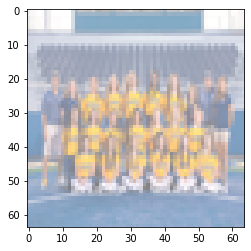

In [38]:
imshow(torchvision.utils.make_grid(images[0]))

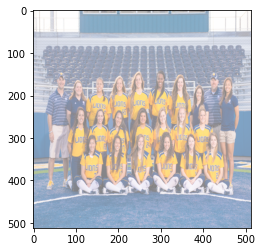

In [39]:
imshow(torchvision.utils.make_grid(labels[0]))

In [40]:
num_epochs = 100
device = torch.device('cpu')

In [41]:
for epoch in range(num_epochs):
    for i, (lr_images, hr_images) in enumerate(tqdm(data_loader)):
        # Move data to the GPU
        lr_images = lr_images.to(device=device)
        hr_images = hr_images.to(device=device)

        # Forward pass
        outputs = model2SR(lr_images)
        loss = loss_function(outputs, hr_images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('Epoch:', epoch, 'Loss:', loss.item())

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 0 Loss: 0.01542816311120987


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 1 Loss: 0.010236434638500214


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 2 Loss: 0.011490661650896072


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 3 Loss: 0.009932074695825577


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 4 Loss: 0.008555200882256031


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 5 Loss: 0.01199700403958559


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 6 Loss: 0.007206678856164217


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 7 Loss: 0.00814868789166212


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 8 Loss: 0.008750656619668007


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 9 Loss: 0.006852931808680296


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 10 Loss: 0.007793210446834564


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 11 Loss: 0.00707130366936326


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 12 Loss: 0.007131557911634445


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 13 Loss: 0.008291530422866344


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 14 Loss: 0.007633332163095474


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 15 Loss: 0.008911789394915104


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 16 Loss: 0.010302784852683544


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 17 Loss: 0.006496664602309465


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 18 Loss: 0.007181400433182716


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 19 Loss: 0.007192015182226896


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 20 Loss: 0.006835192441940308


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 21 Loss: 0.008726054802536964


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 22 Loss: 0.008691643364727497


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 23 Loss: 0.008518359623849392


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 24 Loss: 0.009031941182911396


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 25 Loss: 0.008494182489812374


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 26 Loss: 0.0092148557305336


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 27 Loss: 0.0070550753735005856


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 28 Loss: 0.0062231142073869705


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 29 Loss: 0.009880396537482738


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 30 Loss: 0.008808719925582409


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 31 Loss: 0.0077935573644936085


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 32 Loss: 0.005556976422667503


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 33 Loss: 0.008367124944925308


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 34 Loss: 0.009852827526628971


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 35 Loss: 0.008234750479459763


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 36 Loss: 0.009907864965498447


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 37 Loss: 0.008054363541305065


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 38 Loss: 0.008597910404205322


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 39 Loss: 0.006816673558205366


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 40 Loss: 0.007243370171636343


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 41 Loss: 0.006363061722368002


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 42 Loss: 0.006205575540661812


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 43 Loss: 0.008122998289763927


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 44 Loss: 0.00736611383035779


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 45 Loss: 0.007190802600234747


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 46 Loss: 0.006345286965370178


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 47 Loss: 0.0070829931646585464


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 48 Loss: 0.006218449678272009


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 49 Loss: 0.006227908190339804


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 50 Loss: 0.00717785581946373


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 51 Loss: 0.0067320577800273895


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 52 Loss: 0.007655626628547907


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 53 Loss: 0.007767919916659594


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 54 Loss: 0.008329295553267002


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 55 Loss: 0.010440106503665447


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 56 Loss: 0.007146993651986122


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 57 Loss: 0.008382637053728104


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 58 Loss: 0.008210734464228153


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 59 Loss: 0.008531874045729637


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 60 Loss: 0.008574694395065308


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 61 Loss: 0.006903280969709158


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 62 Loss: 0.009602365083992481


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 63 Loss: 0.00679793069139123


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 64 Loss: 0.008703738451004028


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 65 Loss: 0.0075510963797569275


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 66 Loss: 0.006351417396217585


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 67 Loss: 0.007423963397741318


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 68 Loss: 0.0065194484777748585


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 69 Loss: 0.012178030796349049


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 70 Loss: 0.00766449561342597


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 71 Loss: 0.009098801761865616


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 72 Loss: 0.007340306881815195


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 73 Loss: 0.008715086616575718


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 74 Loss: 0.007908805273473263


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 75 Loss: 0.005261000245809555


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 76 Loss: 0.009391550906002522


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 77 Loss: 0.008502817712724209


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 78 Loss: 0.007349739316850901


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 79 Loss: 0.0058008222840726376


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 80 Loss: 0.007967496290802956


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 81 Loss: 0.006638805847615004


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 82 Loss: 0.008416242897510529


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 83 Loss: 0.007827168330550194


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 84 Loss: 0.008150271140038967


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 85 Loss: 0.006833165418356657


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 86 Loss: 0.00810164026916027


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 87 Loss: 0.007052747532725334


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 88 Loss: 0.0073399594984948635


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 89 Loss: 0.005809111054986715


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 90 Loss: 0.007566638290882111


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 91 Loss: 0.00750741409137845


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 92 Loss: 0.008233862929046154


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 93 Loss: 0.00736328586935997


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 94 Loss: 0.006991328671574593


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 95 Loss: 0.007842014543712139


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 96 Loss: 0.00876053050160408


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 97 Loss: 0.009149320423603058


  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

Epoch: 98 Loss: 0.007259857375174761


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:03<00:00,  6.06s/it]

Epoch: 99 Loss: 0.005465377122163773


In [42]:
dataiter = iter(data_loader)
images, labels = next(dataiter)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


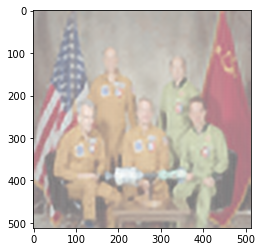

In [43]:
Restoration = model2SR(images.to(device=device))
imshow(torchvision.utils.make_grid(Restoration[0]))

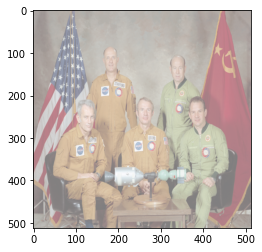

In [44]:
imshow(torchvision.utils.make_grid(labels[0]))